# Analyzing the Data of Top 200 songs on Spotify
## Amanuel Awoke
##  Ferzam Mohammad
## Josue Velasquez



![d](https://i.guim.co.uk/img/media/ae483ce4f1bfc5497fee1b5387711d1ff0172ec9/232_0_3268_1963/master/3268.jpg?width=1200&quality=85&auto=format&fit=max&s=fcfceea59329a6bee9c9b75dd8d7a055)

[Image from The Guardian](https://www.theguardian.com/music/2020/mar/19/musicians-ask-spotify-to-triple-payments-to-cover-lost-concert-revenue)

# Introduction
## Motivation
The music industry has changed a lot in the last decade with the introduction of streaming services like Apple Music or Spotify. Services like Spotify allow users to livestream music for personal consumption, often for free or for a subscription fee. These services have made it easier to consume music and have increased opportunities for people to start producing music, but they have also changed how musicians make money. Whenever a user listens to a song on a streaming service, the service typically keeps track of the number of “plays” that song has. Music artists are then paid a small amount based on the number of plays they have accumulated for their music. Given how little these artists are paid from streaming services, maximizing the amount of revenue made from a song seems pretty valuable for those looking to push out music to these services. Play count also indicates where a song stands in the streaming services’ popularity lists, and making it onto their top 100 or 200 songs is a factor considered in whether these songs are added to global, official top songs charts i.e. Billboard 200.
 
Our group thought it would be interesting to see if we could try to make predictions for how popular a song might be given different features for a song (e.g. the genre of the song, how fast or slow it is, the key the song is written in, the time of year a song was released, how many listeners an artist already gets on average, etc.). If we can indicate how many plays a song will get, we can give a prediction for how much money a song will make on a streaming service. Much like the Moneyball scenario, it’s possible that artists are focusing on producing music that meets criteria which they think makes a song popular when, in reality, they should be focusing on other aspects of their music. Understanding what components of a song make it popular would help artists figure out the best way to produce music in order to make money off of these streaming services.

The Moneyball story demonstrated the importance of data science in producing a strong baseball team, and while music is different from sports, our project should hopefully reflect similar data science practices in order to reach a valuable conclusion. It may be relatively straightforward to look at aspects like which genres make the most money or whether a song by Taylor Swift will end up on the top 200 chart given her “incredibly loyal fanbase” of over 40 million people, but maybe there are other similarities between popular songs that could indicate factors which help make a song more popular. Data science practices like t-tests (maybe) or machine learning models help us here by giving us tools to help identify characteristics in a song, clarify how those characteristics might relate to play count, and predict what the play count (or popularity) for a similar song could be given factors that we have determined have an affect on play count (or popularity)
<One valuable conclusion might be the LACK OF money artists are being paid from streaming services, or how little they make off streaming services alone>

From this point forward when we use the word "track" it is synonymous with "song."

## Goal Hypothesis
Are there traits of a song that can be used to determine future success? If so, what are they?
## Defining Success
We are defining the success of a track by its appearance on the Top 200, as well as its ranking on the Top 200 (the higher the better).


# Collect Data

This is the first step in the data lifecycle where we must identify information to web scrape. We gather data from the [Spotify Charts Regional Top 200](https://spotifycharts.com/regional) to first identify which songs had the highest stream counts in the United States, dating back to January 1st 2017, to current day. Spotify Charts provides tracks with the highest stream count, their top 200 rank, and the artist(s) who created that song. Spotify Charts already compiles the data into Excel tables, so it isn't necessary to directly scrape from the website. If you wanted to download one yourself, at the top right of the website, select a date you'd like to download in the dropdown, then select further up "Download to CSV." The pandas method read_csv() was used to process the Excel files into dataframes.



In [216]:
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
import spotipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Since there were consistent download URLs of Excel sheets in relation to the date they recorded, we used a looped to retreive the links then later download all sheets.

In [217]:
# Collect links from spotify charts top 200 streams per day
ref_str = "https://spotifycharts.com/regional/global/daily/"
ref_arr = []
# gets every day from janurary 2017 to October 2020

for year in range(2017, 2018):
    date = ""
    
    endingMonth = 12
    if year == 2020:
        endingMonth = 10
        
    for month in range (1, endingMonth + 1):
       
        dayCount = -1

        #gets proper day count per month
        thirtyDayCountMonths = [4, 6, 9, 11]
        if month == 2:
            dayCount = 29
        elif month in thirtyDayCountMonths:
            dayCount = 30
        else:
            dayCount = 31

        if int(month) < 10:
            month = "0" + str(month)
        # for day in range (1, daycount + 1):
        # for day in range (1, 16):
           
        #if int(day) < 10:
        #    day = "0" + str(day)

        date = str(year) + "-" + str(month) + "-" + "01" + "/download"
        date = ref_str + date
        ref_arr.append(date)

ref_arr

['https://spotifycharts.com/regional/global/daily/2017-01-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-02-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-03-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-04-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-05-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-06-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-07-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-08-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-09-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-10-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-11-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-12-01/download']

In [218]:
#Loop downloading and appending of dataframes 

df = pd.DataFrame(columns =['position', 'track_name', 'artist', 'streams', 'url', 'date'] )
#make dir to save to
path = "sheets"
folderExists = False
try:
    os.mkdir(path)
except FileExistsError:
    print ("Folder already exists")
    folderExists = True

for i in ref_arr:

    r = requests.get(i, allow_redirects = True)
    #String manipulation to read from the correct csv files
    date = i[48:58]
    fileName = "regional-global-daily-" + date + ".csv"
    if not folderExists:
        print("Downloading... " + fileName)
        open(fileName, "wb").write(r.content)

        os.rename(fileName, "sheets/" + fileName)

    df_new = pd.read_csv(path + "/" + fileName)
    df_new.columns= ['position', 'track_name', 'artist', 'streams', 'url']
    df_new['date'] = date
    
    df_new = df_new.iloc[1:] #deletes junk row from csv conversion
    df = df.append(df_new)

print("Done")
df = df.reset_index() # Sets index back to being the regular 0-based index. This is really helpful when trying to add more to the dataframe later, because otherwise there are lots of duplicate indices
df['streams'] = df['streams'].astype(int) #streams are a string of a num, must wrap as type int always

Folder already exists
Done


## Wrangled data into dataframe

In [219]:
df

index position                               track_name  \
0         1        1                                  Starboy   
1         2        2                                   Closer   
2         3        3                          Let Me Love You   
3         4        4  Rockabye (feat. Sean Paul & Anne-Marie)   
4         5        5                                One Dance   
...     ...      ...                                      ...   
2395    196      196  Rockabye (feat. Sean Paul & Anne-Marie)   
2396    197      197           Rake It Up (feat. Nicki Minaj)   
2397    198      198       New Freezer (feat. Kendrick Lamar)   
2398    199      199                                All Night   
2399    200      200                                      113   

                artist  streams  \
0           The Weeknd  3135625   
1     The Chainsmokers  3015525   
2             DJ Snake  2545384   
3         Clean Bandit  2356604   
4                Drake  2259887   
...                ...      ...   
2395      Clean Bandit   552118   
2396          Yo Gotti   551576   
2397      Rich The Kid   550167   
2398        Steve Aoki   548039   
2399             Booba   546878   

                                                    url        date  
0     https://open.spotify.com/track/5aAx2yezTd8zXrk...  2017-01-01  
1     https://open.spotify.com/track/7BKLCZ1jbUBVqRi...  2017-01-01  
2     https://open.spotify.com/track/4pdPtRcBmOSQDlJ...  2017-01-01  
3     https://open.spotify.com/track/5knuzwU65gJK7IF...  2017-01-01  
4     https://open.spotify.com/track/1xznGGDReH1oQq0...  2017-01-01  
...                                                 ...         ...  
2395  https://open.spotify.com/track/5knuzwU65gJK7IF...  2017-12-01  
2396  https://open.spotify.com/track/4knL4iPxPOZjQzT...  2017-12-01  
2397  https://open.spotify.com/track/4pYZLpX23Vx8rwD...  2017-12-01  
2398  https://open.spotify.com/track/5mAxA6Q1SIym6dP...  2017-12-01  
2399  https://open.spotify.com/track/6xqAP7kpdgCy8lE...  2017-12-01  

[2400 rows x 7 columns]

# Data Processing

[Spotipy](https://spotipy.readthedocs.io/en/2.16.1/#) is a lightweight Python library for the [Spotify Web API](https://developer.spotify.com/documentation/web-api/) used to retrieve more detailed data for tracks now that their names have been retrieved from the Spotify Top 200. We must first authenticate our usage of the API.

In [220]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials


SPOTIPY_CLIENT_ID="ea1a162fbc6f413990542b76ab82a168"
SPOTIPY_CLIENT_SECRET="a09882042ce54f158fdd2b6baaf2b26d"
SPOTIPY_CLIENT_REDIRECT="http://www.cs.umd.edu/class/fall2020/cmsc320-0201/"

scope = "user-library-read"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET, redirect_uri=SPOTIPY_CLIENT_REDIRECT))



We're going to start by using the Spotify API to get more information about all the tracks we found in the top 200's chart for the timeframe we described above. The Spotify API gives us the ability to get "audio features" from a song given a song id that Spotify creates for every track. These "audio features" include characteristics like loudness, positivity, danceability, how energetic the song is, the speed of the song, and a couple other similar characteristics that have been determined by Spotify using their own machine learning algorithms.

First, we do need to get an id for every song and artist in our dataframe to be able to make queries through the Spotify API for a specific track or artist. Here, we get track and artist ids, and we also make a query for the audio features of each track id. We're doing these together for code efficiency, just because a large number of queries through the Spotify API can take time.

In [221]:
import xlsxwriter
import openpyxl

artist_id_list = []
track_id_list = []
popularity_index_list = []
follower_count_list = []
audio_features_df = pd.DataFrame()

genre_list = []
genre_filter = ["rap", "pop", "edm", "rock", "other"]



#if cached df exists dont search again, else search again
if not os.path.exists("cached_df.xlsx"):
    #Take each song and lookup its audio features, then create a dataframe for them
    print("Searching...")
    for index, row in df.iterrows():
        trackName = row['track_name']
        track_id = ""
        artist_id = ""
        # We need to check if our track_name received was a nan value. Idk how these got in here, but there are nans
        if(type(trackName) == str):
            #delimit with +'s for spotipy search query
            trackNameWithoutSpaces = '+'.join(trackName.split())
            searchQuery = sp.search(trackNameWithoutSpaces, 1, 0)
            if (len(searchQuery['tracks']['items']) != 0):
                
                track_object = searchQuery['tracks']['items'][0]
                track_id = track_object['id']
                track_id_list.append(track_id)

                #if there are several artists, return the first artist
                artist_object = track_object['artists'][0] if type(track_object['artists']) is list else track_object['artists']
                artist_id = artist_object['id']
                artist_id_list.append(artist_id)

    
                artist_object_real = sp.artist(artist_id)
                # print(artist_object_real)
                followers_object = artist_object_real['followers']
                followers_value = followers_object['total']
                follower_count_list.append(followers_value)
                popularity_value = artist_object_real['popularity']
                popularity_index_list.append(popularity_value)

                # if artist_object_real['genres']
                    # genre_value = "Rap"
                # genre_list.append(genre_value)
                # print(genre_list)



                # print(popularity_index_list)


            # If our query returned nothing then append a nan in the place of artist and track for this entry
            else:
                artist_id_list.append(np.nan)
                track_id_list.append(np.nan)
                
                popularity_index_list.append(np.nan)
                follower_count_list.append(np.nan)

                genre_list.append(np.nan)
        # If we had stored a nan, then just plan to append a nan in this position
        else:
            artist_id_list.append(np.nan)
            track_id_list.append(np.nan)
            
            popularity_index_list.append(np.nan)
            follower_count_list.append(np.nan)

            genre_list.append(np.nan)

       
        #Defining audio features as nan to begin    
        audiofeatures = {'duration_ms' : np.nan, 'key' : np.nan, 'mode' : np.nan, 'time_signature' : np.nan, 'acousticness' : np.nan, 'danceability' : np.nan, 'energy' : np.nan, 'instrumentalness' : np.nan, 'liveness' : np.nan, 'loudness' : np.nan, 'speechiness' : np.nan, 'valence' : np.nan, 'tempo' : np.nan, 'id' : np.nan, 'uri' : np.nan, 'track_href' : np.nan, 'analysis_url' : np.nan, 'type' : np.nan, }

        # If we successfully found a track when we did our search, then get the audio features for that
        if (track_id != ""):
            audiofeatures = sp.audio_features(track_id)[0]
        #Append the audio features
        audio_features_df = audio_features_df.append(audiofeatures, ignore_index=True)

    #adds artist id list 
    audio_features_df['artist_id'] = artist_id_list 
    audio_features_df['popularity_index'] = popularity_index_list
    audio_features_df['follower_count'] = follower_count_list

    # audio_features_df['genre'] = genre_list

    # Store the created data frame into the cache
    writer = pd.ExcelWriter('cached_df.xlsx', engine='openpyxl')
    audio_features_df.to_excel(writer, sheet_name='Sheet1')
    writer.save()
    
else: #access the cached df if it exist
 
    print("Cached dataframe found.")
    audio_features_df = pd.read_excel("cached_df.xlsx", engine = "openpyxl")
    audio_features_df.drop(["Unnamed: 0"], axis=1, inplace=True) #delete position row since rank alraedy has this information

audio_features_df

Cached dataframe found.


acousticness                                       analysis_url  \
0          0.14100  https://api.spotify.com/v1/audio-analysis/7MXV...   
1          0.41400  https://api.spotify.com/v1/audio-analysis/7BKL...   
2          0.23500  https://api.spotify.com/v1/audio-analysis/3ibK...   
3          0.40600  https://api.spotify.com/v1/audio-analysis/5knu...   
4          0.00776  https://api.spotify.com/v1/audio-analysis/1zi7...   
...            ...                                                ...   
2395       0.40600  https://api.spotify.com/v1/audio-analysis/5knu...   
2396       0.02200  https://api.spotify.com/v1/audio-analysis/4knL...   
2397       0.04050  https://api.spotify.com/v1/audio-analysis/2EgB...   
2398       0.00410  https://api.spotify.com/v1/audio-analysis/0dXN...   
2399       0.00805  https://api.spotify.com/v1/audio-analysis/0leV...   

      danceability  duration_ms  energy                      id  \
0            0.679     230453.0   0.587  7MXVkk9YMctZqd1Srtv4MB   
1            0.748     244960.0   0.524  7BKLCZ1jbUBVqRi2FVlTVw   
2            0.656     256733.0   0.578  3ibKnFDaa3GhpPGlOUj7ff   
3            0.720     251088.0   0.763  5knuzwU65gJK7IF5yJsuaW   
4            0.792     173987.0   0.625  1zi7xx7UVEFkmKfv06H8x0   
...            ...          ...     ...                     ...   
2395         0.720     251088.0   0.763  5knuzwU65gJK7IF5yJsuaW   
2396         0.910     276333.0   0.444  4knL4iPxPOZjQzTUlELGSY   
2397         0.884     191938.0   0.698  2EgB4n6XyBsuNUbuarr4eG   
2398         0.538     197640.0   0.804  0dXNQ8dckG4eYfEtq9zcva   
2399         0.740     266672.0   0.510  0leVyLipY7A8ruhkIBqc0E   

      instrumentalness  key  liveness  loudness  ...  speechiness    tempo  \
0             0.000006  7.0     0.137    -7.015  ...       0.2760  186.003   
1             0.000000  8.0     0.111    -5.599  ...       0.0338   95.010   
2             0.000000  7.0     0.118    -8.970  ...       0.0922   94.514   
3             0.000000  9.0     0.180    -4.068  ...       0.0523  101.965   
4             0.001800  1.0     0.329    -5.609  ...       0.0536  103.967   
...                ...  ...       ...       ...  ...          ...      ...   
2395          0.000000  9.0     0.180    -4.068  ...       0.0523  101.965   
2396          0.000000  1.0     0.137    -8.126  ...       0.3440  149.953   
2397          0.000000  0.0     0.195    -9.101  ...       0.3640  140.068   
2398          0.000000  8.0     0.330    -5.194  ...       0.0358  144.992   
2399          0.000375  9.0     0.128    -8.042  ...       0.0780  141.534   

      time_signature                                         track_href  \
0                4.0  https://api.spotify.com/v1/tracks/7MXVkk9YMctZ...   
1                4.0  https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...   
2                4.0  https://api.spotify.com/v1/tracks/3ibKnFDaa3Gh...   
3                4.0  https://api.spotify.com/v1/tracks/5knuzwU65gJK...   
4                4.0  https://api.spotify.com/v1/tracks/1zi7xx7UVEFk...   
...              ...                                                ...   
2395             4.0  https://api.spotify.com/v1/tracks/5knuzwU65gJK...   
2396             4.0  https://api.spotify.com/v1/tracks/4knL4iPxPOZj...   
2397             4.0  https://api.spotify.com/v1/tracks/2EgB4n6XyBsu...   
2398             4.0  https://api.spotify.com/v1/tracks/0dXNQ8dckG4e...   
2399             5.0  https://api.spotify.com/v1/tracks/0leVyLipY7A8...   

                type                                   uri valence  \
0     audio_features  spotify:track:7MXVkk9YMctZqd1Srtv4MB   0.486   
1     audio_features  spotify:track:7BKLCZ1jbUBVqRi2FVlTVw   0.661   
2     audio_features  spotify:track:3ibKnFDaa3GhpPGlOUj7ff   0.556   
3     audio_features  spotify:track:5knuzwU65gJK7IF5yJsuaW   0.742   
4     audio_features  spotify:track:1zi7xx7UVEFkmKfv06H8x0   0.370   
...              ...                                   ...     ...

In [222]:

#Append audio features to master dataframe
df['track_id'] = audio_features_df['id']
df['duration_ms'] = audio_features_df['duration_ms']
df['acousticness'] = audio_features_df['acousticness']
df['danceability'] = audio_features_df['danceability']
df['energy'] = audio_features_df['energy']
df['instrumentalness'] = audio_features_df['instrumentalness']
df['liveness'] = audio_features_df['liveness']
df['loudness'] = audio_features_df['loudness']
df['speechiness'] = audio_features_df['speechiness']
df['valence'] = audio_features_df['valence']
df['tempo'] = audio_features_df['tempo']
df['artist_id'] = audio_features_df['artist_id']
df['popularity_index'] = audio_features_df['popularity_index']
df['follower_count'] = audio_features_df['follower_count']

df

index position                               track_name  \
0         1        1                                  Starboy   
1         2        2                                   Closer   
2         3        3                          Let Me Love You   
3         4        4  Rockabye (feat. Sean Paul & Anne-Marie)   
4         5        5                                One Dance   
...     ...      ...                                      ...   
2395    196      196  Rockabye (feat. Sean Paul & Anne-Marie)   
2396    197      197           Rake It Up (feat. Nicki Minaj)   
2397    198      198       New Freezer (feat. Kendrick Lamar)   
2398    199      199                                All Night   
2399    200      200                                      113   

                artist  streams  \
0           The Weeknd  3135625   
1     The Chainsmokers  3015525   
2             DJ Snake  2545384   
3         Clean Bandit  2356604   
4                Drake  2259887   
...                ...      ...   
2395      Clean Bandit   552118   
2396          Yo Gotti   551576   
2397      Rich The Kid   550167   
2398        Steve Aoki   548039   
2399             Booba   546878   

                                                    url        date  \
0     https://open.spotify.com/track/5aAx2yezTd8zXrk...  2017-01-01   
1     https://open.spotify.com/track/7BKLCZ1jbUBVqRi...  2017-01-01   
2     https://open.spotify.com/track/4pdPtRcBmOSQDlJ...  2017-01-01   
3     https://open.spotify.com/track/5knuzwU65gJK7IF...  2017-01-01   
4     https://open.spotify.com/track/1xznGGDReH1oQq0...  2017-01-01   
...                                                 ...         ...   
2395  https://open.spotify.com/track/5knuzwU65gJK7IF...  2017-12-01   
2396  https://open.spotify.com/track/4knL4iPxPOZjQzT...  2017-12-01   
2397  https://open.spotify.com/track/4pYZLpX23Vx8rwD...  2017-12-01   
2398  https://open.spotify.com/track/5mAxA6Q1SIym6dP...  2017-12-01   
2399  https://open.spotify.com/track/6xqAP7kpdgCy8lE...  2017-12-01   

                    track_id  duration_ms  acousticness  ...  energy  \
0     7MXVkk9YMctZqd1Srtv4MB     230453.0       0.14100  ...   0.587   
1     7BKLCZ1jbUBVqRi2FVlTVw     244960.0       0.41400  ...   0.524   
2     3ibKnFDaa3GhpPGlOUj7ff     256733.0       0.23500  ...   0.578   
3     5knuzwU65gJK7IF5yJsuaW     251088.0       0.40600  ...   0.763   
4     1zi7xx7UVEFkmKfv06H8x0     173987.0       0.00776  ...   0.625   
...                      ...          ...           ...  ...     ...   
2395  5knuzwU65gJK7IF5yJsuaW     251088.0       0.40600  ...   0.763   
2396  4knL4iPxPOZjQzTUlELGSY     276333.0       0.02200  ...   0.444   
2397  2EgB4n6XyBsuNUbuarr4eG     191938.0       0.04050  ...   0.698   
2398  0dXNQ8dckG4eYfEtq9zcva     197640.0       0.00410  ...   0.804   
2399  0leVyLipY7A8ruhkIBqc0E     266672.0       0.00805  ...   0.510   

      instrumentalness  liveness  loudness  speechiness  valence    tempo  \
0             0.000006     0.137    -7.015       0.2760    0.486  186.003   
1             0.000000     0.111    -5.599       0.0338    0.661   95.010   
2             0.000000     0.118    -8.970       0.0922    0.556   94.514   
3             0.000000     0.180    -4.068       0.0523    0.742  101.965   
4             0.001800     0.329    -5.609       0.0536    0.370  103.967   
...                ...       ...       ...          ...      ...      ...   
2395          0.000000     0.180    -4.068       0.0523    0.742  101.965   
2396          0.000000     0.137    -8.126       0.3440    0.530  149.953   
2397          0.000000     0.195    -9.101       0.3640    0.575  140.068   
2398          0.000000     0.330    -5.194       0.0358    0.507  144.992   
2399          0.000375     0.128    -8.042       0.0780    0.089  141.534   

                   artist_id popularity_index  follower_count  
0     1Xyo4u8uXC1ZmMpatF05PJ             94.0      26720759.0  
1     69GGBxA162lTqCwzJG5jLp     

In [223]:
#visualization
#plotting all the new metrics in our dataframe vs streams
df['streams'] = df['streams'].astype(float)
df['position'] = df['position'].astype(int)
#this shows what got number 1? (below)
# df.loc[df['position'] == 1].head(10) # Previously this was showing that every 

# Data Visualization

We've now gathered and manipulated valuable data for each track for each day recorded. The key elements are the following:
- Track Name
- Artist Name
- Stream Count
- Popularity value 
- Number of Followers
- Position on Top 200
- Date on the Top 200 (most songs stay for many days)

The following details define the patterns and properties of music, the way they sound, and what mood they instill:
- Duration
  - The duration of the track in milliseconds.
- Acousticness
  - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. 
- Energy
  - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 
- Instrumentalness
  - Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- Liveness
  - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- Loudness
  - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
- Speechiness 
  - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 
- Valence
  - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). 
- Tempo
  - The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

The following are more extraneous details for identifying tracks in the data wrangling:
- Track ID
- Artist ID 
- URL



Using this data, we begin trying to observe what traits of a song bring success.
First we observe that there is a standard distrubtion of stream counts, meaning the mean stream count will most likely fall from 1-1.05 million.

Text(0, 0.5, 'Frequency')

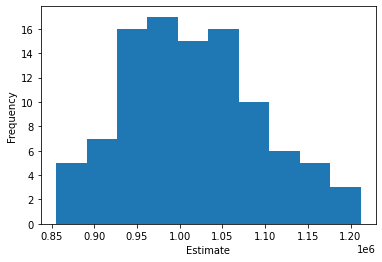

In [224]:
#Histogram takes 100 random tracks, takes the average of all their streams, then does this 100 times
#Is a standarrd deviation


from scipy.stats import normaltest
from numpy.random import seed
from numpy.random import randn


alpha = 0.05
data = []
for i in range(0,100):
    data.append(np.mean(df['streams'].sample(n=100)))
plt.hist(data)
plt.xlabel("Estimate")
plt.ylabel("Frequency")


Our goal is to determine if there certain values of song properties that result in extremely high or low success.
We create a dataframe that only saves the entry of a song at its peak stream count in the Top 200, meaning
we are comparing all the peaks.

In [225]:
# Creating version of table with no duplicates, keeping the last seen version of each song. It is a fair representation of success.

no_dupes_df = df.copy()
no_dupes_df = no_dupes_df.sort_values('streams', ascending=False).drop_duplicates(['artist', 'duration_ms', 'acousticness', 'danceability', 'energy'], keep='first') 
no_dupes_df

index  position                     track_name         artist  \
200       1         1                   Shape of You     Ed Sheeran   
1000      1         1              Despacito - Remix     Luis Fonsi   
2000      1         1                       rockstar    Post Malone   
1600      1         1       Look What You Made Me Do   Taylor Swift   
1001      2         2                    I'm the One      DJ Khaled   
...     ...       ...                            ...            ...   
193     194       194                         Famous     Kanye West   
196     197       197                        Oh Lord      MiC LOWRY   
197     198       198  Superstition - Single Version  Stevie Wonder   
198     199       199                        Secrets     The Weeknd   
199     200       200                Ni**as In Paris          JAY-Z   

        streams                                                url  \
200   7549041.0  https://open.spotify.com/track/7qiZfU4dY1lWllz...   
1000  7332260.0  https://open.spotify.com/track/5CtI0qwDJkDQGwX...   
2000  5755610.0  https://open.spotify.com/track/7wGoVu4Dady5GV0...   
1600  5547962.0  https://open.spotify.com/track/6uFsE1JgZ20EXyU...   
1001  5208996.0  https://open.spotify.com/track/72Q0FQQo32KJloi...   
...         ...                                                ...   
193    336134.0  https://open.spotify.com/track/19a3JfW8BQwqHWU...   
196    331792.0  https://open.spotify.com/track/1sTUEdVO85YU8Ym...   
197    331376.0  https://open.spotify.com/track/5lXcSvHRVjQJ3LB...   
198    331233.0  https://open.spotify.com/track/3DX4Y0egvc0slLc...   
199    325951.0  https://open.spotify.com/track/2KpCpk6HjXXLb7n...   

            date                track_id  duration_ms  acousticness  ...  \
200   2017-02-01  7qiZfU4dY1lWllzX7mPBI3     233713.0        0.5810  ...   
1000  2017-06-01  6rPO02ozF3bM7NnOV4h6s2     228827.0        0.2280  ...   
2000  2017-11-01  7ytR5pFWmSjzHJIeQkgog4     181733.0        0.2470  ...   
1600  2017-09-01  1P17dC1amhFzptugyAO7Il     211853.0        0.2040  ...   
1001  2017-06-01  1jYiIOC5d6soxkJP81fxq2     288877.0        0.0533  ...   
...          ...                     ...          ...           ...  ...   
193   2017-01-01  19a3JfW8BQwqHWUMbcqSx8     196040.0        0.0711  ...   
196   2017-01-01  1ISsiC4Fw6f96kZQegLGiJ     198253.0        0.4070  ...   
197   2017-01-01  1h2xVEoJORqrg71HocgqXd     245493.0        0.0380  ...   
198   2017-01-01  1NhPKVLsHhFUHIOZ32QnS2     224693.0        0.0717  ...   
199   2017-01-01  4Li2WHPkuyCdtmokzW2007     219333.0        0.1270  ...   

      energy  instrumentalness  liveness  loudness  speechiness  valence  \
200    0.652          0.000000    0.0931    -3.183       0.0802    0.931   
1000   0.816          0.000000    0.0967    -4.353       0.1670    0.816   
2000   0.690          0.000000    0.1010    -7.956       0.1640    0.497   
1600   0.709          0.000014    0.1260    -6.471       0.1230    0.506   
1001   0.667          0.000000    0.1340    -4.267       0.0367    0.817   
...      ...               ...       ...       ...          ...      ...   
193    0.735          0.000000    0.0975    -3.715       0.1170    0.409   
196    0.738          0.000000    0.1300    -6.921       0.2620    0.219   
197    0.634          0.006400    0.0385   -12.115       0.0725    0.872   
198    0.764          0.000000    0.1150    -6.223       0.0366    0.376   
199    0.858          0.000000    0.3490    -5.542       0.3110    0.775   

        tempo               artist_id popularity_index  follower_count  
200    95.977  6eUKZXaKkcviH0Ku9w2n3V             91.0      73345259.0  
1000  178.085  4V8Sr092TqfHkfAA5fXXqG             78.0       9035487.0  
2000   89.977  4r63FhuTkUYltbVAg5TQnk             93.0       5174251.0  
1600  128.070  06HL4z0CvFAxyc27GXpf02             97.0      34579892.0  
1001   80.984  0QHgL1lAIqAw0HtD7YldmP             82.0       5405048.0  
...       ...                     ...           

Text(0, 0.5, 'streams in millions')

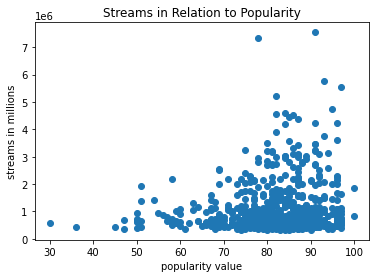

In [226]:
plt.scatter(no_dupes_df['popularity_index'], no_dupes_df['streams'])
plt.title('Streams in Relation to Popularity')
plt.xlabel('popularity value')
plt.ylabel('streams in millions')


Text(0, 0.5, 'streams in millions')

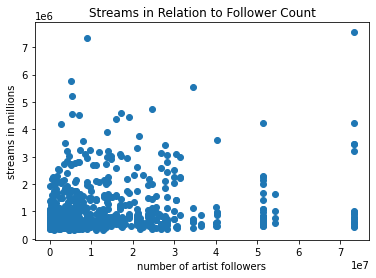

In [227]:
plt.scatter(no_dupes_df['follower_count'], no_dupes_df['streams'])
plt.title('Streams in Relation to Follower Count')
plt.xlabel('number of artist followers')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

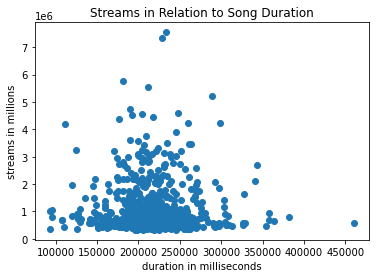

In [228]:
plt.scatter(no_dupes_df['duration_ms'], no_dupes_df['streams'])
plt.title('Streams in Relation to Song Duration')
plt.xlabel('duration in milliseconds')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

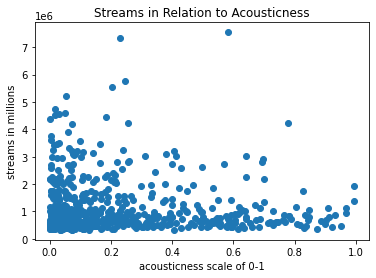

In [229]:
plt.scatter(no_dupes_df['acousticness'],no_dupes_df['streams'])
plt.title('Streams in Relation to Acousticness')
plt.xlabel('acousticness scale of 0-1')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

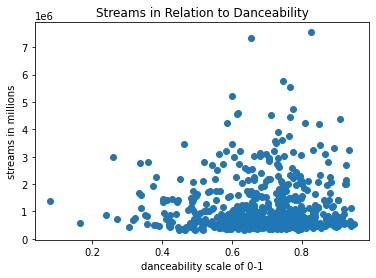

In [230]:
plt.scatter(no_dupes_df['danceability'],no_dupes_df['streams'])
plt.title('Streams in Relation to Danceability')
plt.xlabel('danceability scale of 0-1')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

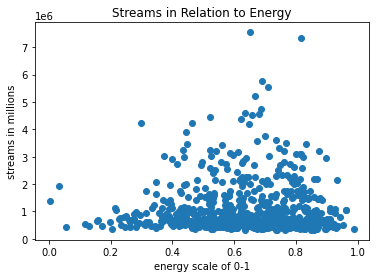

In [231]:
plt.scatter(no_dupes_df['energy'],no_dupes_df['streams'])
plt.title('Streams in Relation to Energy')
plt.xlabel('energy scale of 0-1')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

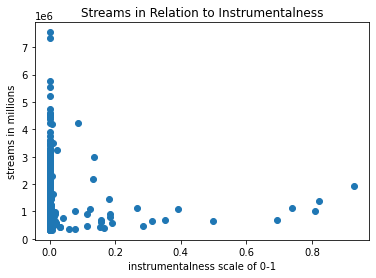

In [232]:
plt.scatter(no_dupes_df['instrumentalness'],no_dupes_df['streams'])
plt.title('Streams in Relation to Instrumentalness')
plt.xlabel('instrumentalness scale of 0-1')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

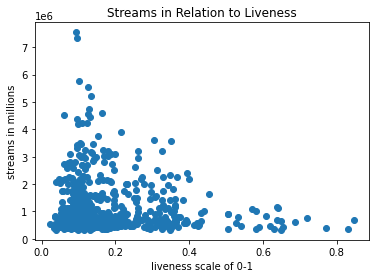

In [233]:
plt.scatter(no_dupes_df['liveness'],no_dupes_df['streams'])
plt.title('Streams in Relation to Liveness')
plt.xlabel('liveness scale of 0-1') 
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

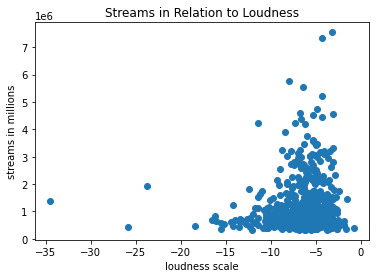

In [234]:
plt.scatter(no_dupes_df['loudness'],no_dupes_df['streams'])
plt.title('Streams in Relation to Loudness')
plt.xlabel('loudness scale')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

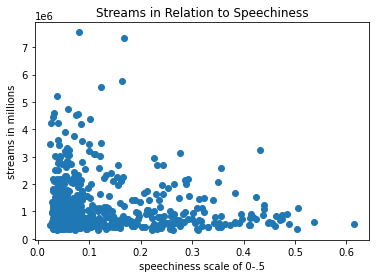

In [235]:
plt.scatter(no_dupes_df['speechiness'], no_dupes_df['streams'])
plt.title('Streams in Relation to Speechiness')
plt.xlabel('speechiness scale of 0-.5')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

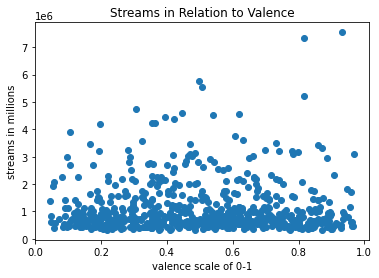

In [236]:
plt.scatter(no_dupes_df['valence'],no_dupes_df['streams'])
plt.title('Streams in Relation to Valence')
plt.xlabel('valence scale of 0-1')
plt.ylabel('streams in millions')

Streams in relation to Tempo

Text(0, 0.5, 'streams in millions')

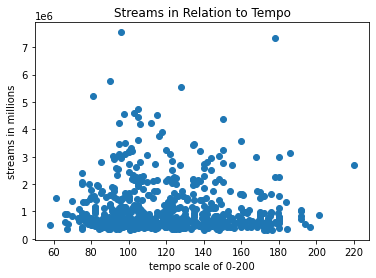

In [237]:
plt.scatter(no_dupes_df['tempo'],no_dupes_df['streams'])
plt.title('Streams in Relation to Tempo')
plt.xlabel('tempo scale of 0-200')
plt.ylabel('streams in millions')

Observe this correlation matrix compiling on scatter plots above

<AxesSubplot:>

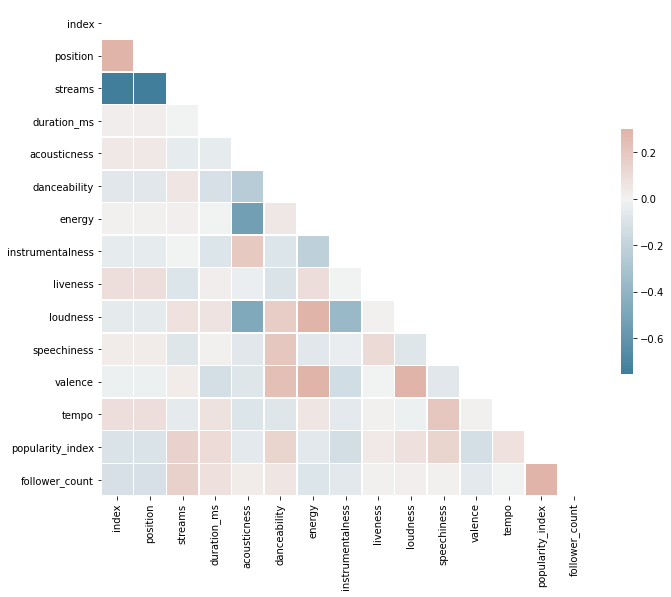

In [238]:
corr = no_dupes_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

It seems like each individual feature has very little effect on the number of streams, which would support our findings above. After seeing this, we had a couple of ideas. It is possible different features we are currently tracking work together to make a song popular, but it is also possible we are missing other important features. After looking back at the most popular songs over the course of our entire dataframe, we noticed the majority of artists were well known or already accomplished. While it is obvious that an artists "followers" or typical listeners will increase the number of streams a song will get, it would be interesting to know if the number of typical listeners was more important than all these other aspects of the song.

### Top 10
Here we observe the traits of specifically the song at the ranks 1-5. This song is likely to change, so there will be different values for the same position at times.

In [239]:
top5s = df.loc[df['position'] <= 10]
#lists for legend to remove redundant code
color_list = ['r', 'orange', 'yellow', 'lime',  'cyan', 'b', 'brown' , 'violet', 'purple', 'black']
top10_legend = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5', 'Rank 6','Rank 7','Rank 8','Rank 9','Rank 10']

#method to remove redundant code in plotting
def plotTop10(name):
    i = 0
    for index, row in top5s.iterrows():
        plt.scatter(row[name],row['streams'], color=color_list[i])
        i = (i + 1) % 10


top5s.head()

index  position                               track_name            artist  \
0      1         1                                  Starboy        The Weeknd   
1      2         2                                   Closer  The Chainsmokers   
2      3         3                          Let Me Love You          DJ Snake   
3      4         4  Rockabye (feat. Sean Paul & Anne-Marie)      Clean Bandit   
4      5         5                                One Dance             Drake   

     streams                                                url        date  \
0  3135625.0  https://open.spotify.com/track/5aAx2yezTd8zXrk...  2017-01-01   
1  3015525.0  https://open.spotify.com/track/7BKLCZ1jbUBVqRi...  2017-01-01   
2  2545384.0  https://open.spotify.com/track/4pdPtRcBmOSQDlJ...  2017-01-01   
3  2356604.0  https://open.spotify.com/track/5knuzwU65gJK7IF...  2017-01-01   
4  2259887.0  https://open.spotify.com/track/1xznGGDReH1oQq0...  2017-01-01   

                 track_id  duration_ms  acousticness  ...  energy  \
0  7MXVkk9YMctZqd1Srtv4MB     230453.0       0.14100  ...   0.587   
1  7BKLCZ1jbUBVqRi2FVlTVw     244960.0       0.41400  ...   0.524   
2  3ibKnFDaa3GhpPGlOUj7ff     256733.0       0.23500  ...   0.578   
3  5knuzwU65gJK7IF5yJsuaW     251088.0       0.40600  ...   0.763   
4  1zi7xx7UVEFkmKfv06H8x0     173987.0       0.00776  ...   0.625   

   instrumentalness  liveness  loudness  speechiness  valence    tempo  \
0          0.000006     0.137    -7.015       0.2760    0.486  186.003   
1          0.000000     0.111    -5.599       0.0338    0.661   95.010   
2          0.000000     0.118    -8.970       0.0922    0.556   94.514   
3          0.000000     0.180    -4.068       0.0523    0.742  101.965   
4          0.001800     0.329    -5.609       0.0536    0.370  103.967   

                artist_id popularity_index  follower_count  
0  1Xyo4u8uXC1ZmMpatF05PJ             94.0      26720759.0  
1  69GGBxA162lTqCwzJG5jLp             84.0      17093912.0  
2  20s0P9QLxGqKuCsGwFsp7w             69.0       2055274.0  
3  6MDME20pz9RveH9rEXvrOM             80.0       4092589.0  
4  3TVXtAsR1Inumwj472S9r4             96.0      51374698.0  

[5 rows x 21 columns]

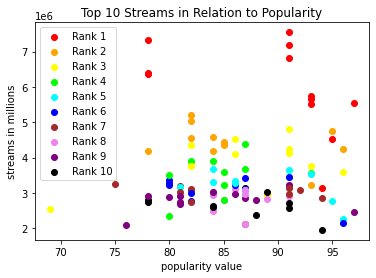

In [240]:

plotTop10('popularity_index')
plt.title('Top 10 Streams in Relation to Popularity')
plt.xlabel('popularity value')
plt.ylabel('streams in millions')
plt.legend(top10_legend)


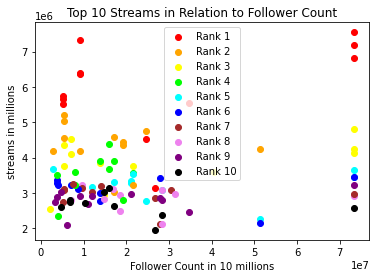

In [241]:
plotTop10('follower_count')
plt.title('Top 10 Streams in Relation to Follower Count')
plt.xlabel('Follower Count in 10 millions')
plt.ylabel('streams in millions')
plt.legend(top10_legend)

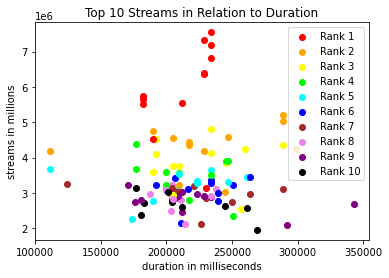

In [242]:
plotTop10('duration_ms')
plt.title('Top 10 Streams in Relation to Duration')
plt.xlabel('duration in milliseconds')
plt.ylabel('streams in millions')
plt.legend(top10_legend)

This graph Shows how the duration of a song in milliseconds compares to the number of streams that song received, and we're only using the first 10 pieces of data from our dataframe. This shows us that the songs with the most streams from this set of data are songs which are > 240000 ms, or 4 minutes. This is surprising, because the average song is usually around 3 minutes and 30 seconds or less.

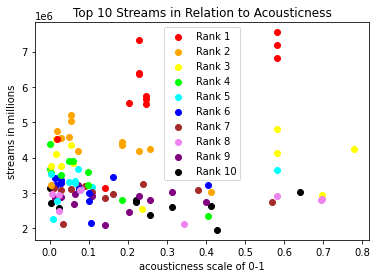

In [243]:
plotTop10('acousticness')
plt.title('Top 10 Streams in Relation to Acousticness')
plt.xlabel('acousticness scale of 0-1')
plt.ylabel('streams in millions')
plt.legend(top10_legend)

This graph displays a confidence score for how likely it is that a song is acoustic (with a value of 1 being very likely that the song is acoustic) compared to the number of streams the song has. All of the confidence scores are less than .5, which indicates most of these songs are probably not acoustic

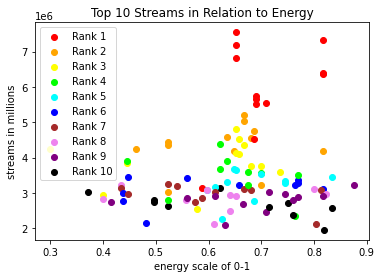

In [244]:

plotTop10('energy')
plt.title('Top 10 Streams in Relation to Energy')
plt.xlabel('energy scale of 0-1')
plt.ylabel('streams in millions')
plt.legend(top10_legend)


This graph shows how the "energy" of a song, or generally how noisy and fast the song is, compares to the number of streams for the top 10 songs on the 1st of January. Here, we see that the songs with the most streams are around or above .6 on the energy scale (a higher score means the song is higher energy)

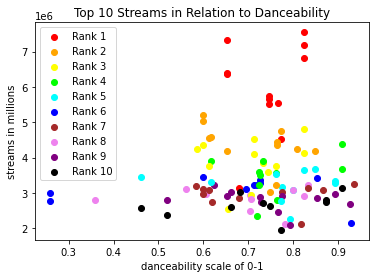

In [245]:
plotTop10('danceability')
plt.title('Top 10 Streams in Relation to Danceability')
plt.xlabel('danceability scale of 0-1')
plt.ylabel('streams in millions')
plt.legend(top10_legend)



This graph shows how "danceable" a song is using a value provided to us by the Spotify API comapred to the number of streams that song got. Danceability is measured as a value from 0 to 1, where 1 is most danceable. This graph appears to be similar to the graph describing, so they may have been determined using similar characteristisc (i.e. both are measuring how upbeat or fast a song is)

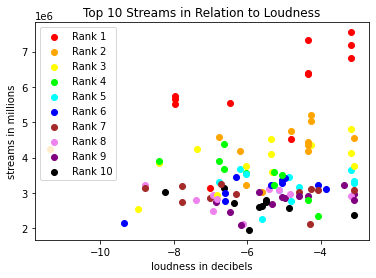

In [246]:

plotTop10('loudness')
plt.title('Top 10 Streams in Relation to Loudness')
plt.xlabel('loudness in decibels')
plt.ylabel('streams in millions')
plt.legend(top10_legend)



This graph describes the average volume of each track in our top 5s data set compared to the number of streams each song had. It appears to trend similarly to the last two graphs, indicating that the volume of a track may be correlated with how danceable or energetic a song is.

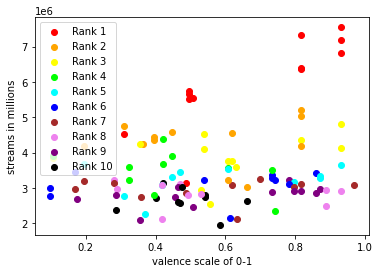

In [247]:

plotTop10('valence')
plt.xlabel('valence scale of 0-1')
plt.ylabel('streams in millions')
plt.legend(top10_legend)



This graph describes the "valence" of a song compared to the # of streams it got. Valence is described as the "positivity" of a song where "Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)," according to the Spotify API reference. The reference does not describe how this value is determined, but our data seems to show there may be a correlation between valence and the number of streams a song is getting in the set of number 1 songs. However, this graph does not take into account the other features for the songs. It may be worth trying to consider songs where features except for this one are held to a constant, so that we can consider if there is a correlation between this value and the number of streams.

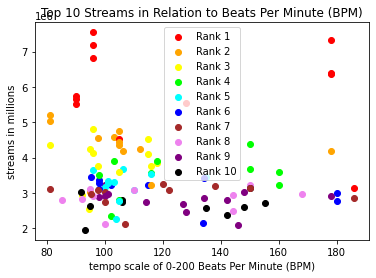

In [248]:

plotTop10('tempo')
plt.title('Top 10 Streams in Relation to Beats Per Minute (BPM)')
plt.xlabel('tempo scale of 0-200 Beats Per Minute (BPM)')
plt.ylabel('streams in millions')
plt.legend(top10_legend)



This graph describes the tempo of a song comapred to the number of streams that song has. Given our dataset, it is unclear whether there is a correlation between the tempo of a song and the number of streams it gets.

### Correlation of the top 10

<AxesSubplot:>

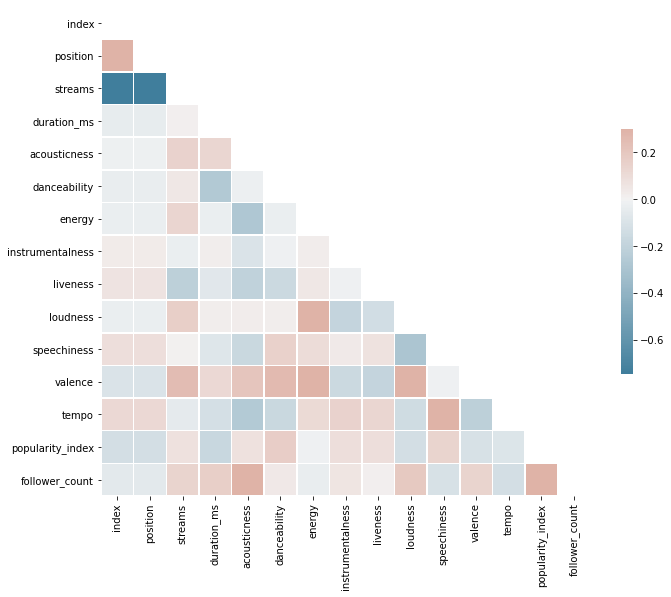

In [249]:
corr = top5s.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Unique Relationships

There appeared to be a potential relationship between valence and the number of streams a song was getting, so it might be interesting to look at what the different features are like for songs with a valence of around .4 or higher

In [250]:
highValenceTopTracks = top5s.loc[top5s['valence'] > .4]
highValenceTopTracks.sort_values('streams', ascending=False).head(10)

index  position                track_name        artist    streams  \
200       1         1              Shape of You    Ed Sheeran  7549041.0   
1000      1         1         Despacito - Remix    Luis Fonsi  7332260.0   
400       1         1              Shape of You    Ed Sheeran  7201132.0   
600       1         1              Shape of You    Ed Sheeran  6815498.0   
1200      1         1         Despacito - Remix    Luis Fonsi  6398530.0   
800       1         1         Despacito - Remix    Luis Fonsi  6360737.0   
2000      1         1                  rockstar   Post Malone  5755610.0   
1800      1         1                  rockstar   Post Malone  5649503.0   
1600      1         1  Look What You Made Me Do  Taylor Swift  5547962.0   
2200      1         1                  rockstar   Post Malone  5528701.0   

                                                    url        date  \
200   https://open.spotify.com/track/7qiZfU4dY1lWllz...  2017-02-01   
1000  https://open.spotify.com/track/5CtI0qwDJkDQGwX...  2017-06-01   
400   https://open.spotify.com/track/7qiZfU4dY1lWllz...  2017-03-01   
600   https://open.spotify.com/track/7qiZfU4dY1lWllz...  2017-04-01   
1200  https://open.spotify.com/track/5CtI0qwDJkDQGwX...  2017-07-01   
800   https://open.spotify.com/track/5CtI0qwDJkDQGwX...  2017-05-01   
2000  https://open.spotify.com/track/7wGoVu4Dady5GV0...  2017-11-01   
1800  https://open.spotify.com/track/1OmcAT5Y8eg5bUP...  2017-10-01   
1600  https://open.spotify.com/track/6uFsE1JgZ20EXyU...  2017-09-01   
2200  https://open.spotify.com/track/7wGoVu4Dady5GV0...  2017-12-01   

                    track_id  duration_ms  acousticness  ...  energy  \
200   7qiZfU4dY1lWllzX7mPBI3     233713.0         0.581  ...   0.652   
1000  6rPO02ozF3bM7NnOV4h6s2     228827.0         0.228  ...   0.816   
400   7qiZfU4dY1lWllzX7mPBI3     233713.0         0.581  ...   0.652   
600   7qiZfU4dY1lWllzX7mPBI3     233713.0         0.581  ...   0.652   
1200  6rPO02ozF3bM7NnOV4h6s2     228827.0         0.228  ...   0.816   
800   6rPO02ozF3bM7NnOV4h6s2     228827.0         0.228  ...   0.816   
2000  7ytR5pFWmSjzHJIeQkgog4     181733.0         0.247  ...   0.690   
1800  7ytR5pFWmSjzHJIeQkgog4     181733.0         0.247  ...   0.690   
1600  1P17dC1amhFzptugyAO7Il     211853.0         0.204  ...   0.709   
2200  7ytR5pFWmSjzHJIeQkgog4     181733.0         0.247  ...   0.690   

      instrumentalness  liveness  loudness  speechiness  valence    tempo  \
200           0.000000    0.0931    -3.183       0.0802    0.931   95.977   
1000          0.000000    0.0967    -4.353       0.1670    0.816  178.085   
400           0.000000    0.0931    -3.183       0.0802    0.931   95.977   
600           0.000000    0.0931    -3.183       0.0802    0.931   95.977   
1200          0.000000    0.0967    -4.353       0.1670    0.816  178.085   
800           0.000000    0.0967    -4.353       0.1670    0.816  178.085   
2000          0.000000    0.1010    -7.956       0.1640    0.497   89.977   
1800          0.000000    0.1010    -7.956       0.1640    0.497   89.977   
1600          0.000014    0.1260    -6.471       0.1230    0.506  128.070   
2200          0.000000    0.1010    -7.956       0.1640    0.497   89.977   

                   artist_id popularity_index  follower_count  
200   6eUKZXaKkcviH0Ku9w2n3V             91.0      73345259.0  
1000  4V8Sr092TqfHkfAA5fXXqG             78.0       9035487.0  
400   6eUKZXaKkcviH0Ku9w2n3V             91.0      73345259.0  
600   6eUKZXaKkcviH0Ku9w2n3V             91.0      73345259.0  
1200  4V8Sr092TqfHkfAA5fXXqG             78.0       9035487.0  
800   4V8Sr092TqfHkfAA5fXXqG             78.0       9035487.0  
2000  4r63FhuTkUYltbVAg5TQnk             93.0       5174251.0  
1800  4r63FhuTkUYltbVAg5TQnk             93.0       5174251.0  
1600  06HL4z0CvFAxyc27GXpf02             97.0      34579892.0  
2200  4r63FhuTkUYltbVAg5TQnk             93.0       5174251.0  

[10 rows x 21 columns]

We have duplicate pieces of data, so lets remove the duplicates for this test. We're going to try to keep the versions of the song that have the most streams

In [251]:
highValenceTopTracks = highValenceTopTracks.sort_values('streams', ascending=False).drop_duplicates(['artist', 'duration_ms', 'acousticness', 'danceability', 'energy'], keep='first') # Keeping the last seen version of each song, as that will probably hold it's total streams more accurately
highValenceTopTracks.sort_values('streams', ascending=False).head(10)

index  position                                     track_name  \
200       1         1                                   Shape of You   
1000      1         1                              Despacito - Remix   
2000      1         1                                       rockstar   
1600      1         1                       Look What You Made Me Do   
1001      2         2                                    I'm the One   
401       2         2                       Something Just Like This   
1201      2         2  Wild Thoughts (feat. Rihanna & Bryson Tiller)   
402       3         3                It Ain't Me (with Selena Gomez)   
803       4         4                                        HUMBLE.   
2002      3         3                                      New Rules   

                artist    streams  \
200         Ed Sheeran  7549041.0   
1000        Luis Fonsi  7332260.0   
2000       Post Malone  5755610.0   
1600      Taylor Swift  5547962.0   
1001         DJ Khaled  5208996.0   
401   The Chainsmokers  4581789.0   
1201         DJ Khaled  4558126.0   
402               Kygo  4529714.0   
803     Kendrick Lamar  4371886.0   
2002          Dua Lipa  3758506.0   

                                                    url        date  \
200   https://open.spotify.com/track/7qiZfU4dY1lWllz...  2017-02-01   
1000  https://open.spotify.com/track/5CtI0qwDJkDQGwX...  2017-06-01   
2000  https://open.spotify.com/track/7wGoVu4Dady5GV0...  2017-11-01   
1600  https://open.spotify.com/track/6uFsE1JgZ20EXyU...  2017-09-01   
1001  https://open.spotify.com/track/72Q0FQQo32KJloi...  2017-06-01   
401   https://open.spotify.com/track/6RUKPb4LETWmmr3...  2017-03-01   
1201  https://open.spotify.com/track/1OAh8uOEOvTDqkK...  2017-07-01   
402   https://open.spotify.com/track/3eR23VReFzcdmS7...  2017-03-01   
803   https://open.spotify.com/track/7KXjTSCq5nL1LoY...  2017-05-01   
2002  https://open.spotify.com/track/2ekn2ttSfGqwhha...  2017-11-01   

                    track_id  duration_ms  acousticness  ...  energy  \
200   7qiZfU4dY1lWllzX7mPBI3     233713.0      0.581000  ...   0.652   
1000  6rPO02ozF3bM7NnOV4h6s2     228827.0      0.228000  ...   0.816   
2000  7ytR5pFWmSjzHJIeQkgog4     181733.0      0.247000  ...   0.690   
1600  1P17dC1amhFzptugyAO7Il     211853.0      0.204000  ...   0.709   
1001  1jYiIOC5d6soxkJP81fxq2     288877.0      0.053300  ...   0.667   
401   6RUKPb4LETWmmr3iAEQktW     247160.0      0.049800  ...   0.635   
1201  45XhKYRRkyeqoW3teSOkCM     204664.0      0.028700  ...   0.681   
402   2jRGYG8U5bJzWOH6FLuzvO     192000.0      0.016100  ...   0.658   
803   7KXjTSCq5nL1LoYtL7XAwS     177000.0      0.000282  ...   0.621   
2002  2ekn2ttSfGqwhhate0LSR0     209320.0      0.002610  ...   0.700   

      instrumentalness  liveness  loudness  speechiness  valence    tempo  \
200           0.000000    0.0931    -3.183       0.0802    0.931   95.977   
1000          0.000000    0.0967    -4.353       0.1670    0.816  178.085   
2000          0.000000    0.1010    -7.956       0.1640    0.497   89.977   
1600          0.000014    0.1260    -6.471       0.1230    0.506  128.070   
1001          0.000000    0.1340    -4.267       0.0367    0.817   80.984   
401           0.000014    0.1640    -6.769       0.0317    0.446  103.019   
1201          0.000000    0.1260    -3.089       0.0778    0.619   97.621   
402           0.000138    0.0607    -5.362       0.0748    0.539  115.024   
803           0.000054    0.0958    -6.638       0.1020    0.421  150.011   
2002          0.000016    0.1530    -6.021       0.0694    0.608  116.073   

                   artist_id popularity_index  follower_count  
200   6eUKZXaKkcviH0Ku9w2n3V             91.0      73345259.0  
1000  4V8Sr092TqfHkfAA5fXXqG             78.0       9035487.0  
2000  4r63FhuTkUYltbVAg5TQnk             93.0       5174251.0  
1600  06HL4z0CvFAxyc27GXpf02             97.0      34579892.0  
1001  0QHgL1lAIqAw0HtD7YldmP             82.0       5405048.0 

In [252]:
highValenceTopTracks = highValenceTopTracks.sort_values('valence', ascending=False)
highValenceTopTracks.head()

index  position                                         track_name  \
1006      7         7                    There's Nothing Holdin' Me Back   
200       1         1                                       Shape of You   
1607      8         8                                    Sorry Not Sorry   
1604      5         5  Feels (feat. Pharrell Williams, Katy Perry & B...   
605       6         6                                 That's What I Like   

             artist    streams  \
1006   Shawn Mendes  3093935.0   
200      Ed Sheeran  7549041.0   
1607    Demi Lovato  2952488.0   
1604  Calvin Harris  3324451.0   
605      Bruno Mars  3419965.0   

                                                    url        date  \
1006  https://open.spotify.com/track/79cuOz3SPQTuFrp...  2017-06-01   
200   https://open.spotify.com/track/7qiZfU4dY1lWllz...  2017-02-01   
1607  https://open.spotify.com/track/25C5CowdsfXld2j...  2017-09-01   
1604  https://open.spotify.com/track/5bcTCxgc7xVfSaM...  2017-09-01   
605   https://open.spotify.com/track/0KKkJNfGyhkQ5aF...  2017-04-01   

                    track_id  duration_ms  acousticness  ...  energy  \
1006  7JJmb5XwzOO8jgpou264Ml     199440.0        0.3800  ...   0.813   
200   7qiZfU4dY1lWllzX7mPBI3     233713.0        0.5810  ...   0.652   
1607  7gvd8xj4QgPqbQSsn5pV7d     203760.0        0.0237  ...   0.640   
1604  5bcTCxgc7xVfSaMV3RuVke     223413.0        0.0642  ...   0.745   
605   0KKkJNfGyhkQ5aFogxQAPU     206693.0        0.0130  ...   0.560   

      instrumentalness  liveness  loudness  speechiness  valence    tempo  \
1006               0.0    0.0779    -4.063       0.0554    0.969  121.998   
200                0.0    0.0931    -3.183       0.0802    0.931   95.977   
1607               0.0    0.2620    -6.928       0.2250    0.887  144.077   
1604               0.0    0.0943    -3.105       0.0571    0.872  101.018   
605                0.0    0.0944    -4.961       0.0406    0.860  134.066   

                   artist_id popularity_index  follower_count  
1006  7n2wHs1TKAczGzO7Dd2rGr             92.0      30441601.0  
200   6eUKZXaKkcviH0Ku9w2n3V             91.0      73345259.0  
1607  6S2OmqARrzebs0tKUEyXyp             84.0      18568349.0  
1604  7CajNmpbOovFoOoasH2HaY             86.0      20962353.0  
605   0du5cEVh5yTK9QJze8zA0C             87.0      27863749.0  

[5 rows x 21 columns]

We believe no one feature has a strong effect on the number of streams, but it's possible that a combination of values in different features work together to improve stream count.

Using our list of songs with a high valence, we can look at the relationship between featuers like danceability or tempo and stream count to try to see how songs with both a high valence and varying levels of these features affect streams.

Let's get high valence songs from our original dataframe to have a larger sample size

In [253]:
highValenceTracks = df.loc[(df['valence'] > .5) & (df['valence'] < .8)]
veryHighValenceTracks = df.loc[df['valence'] > .8]
lowValenceTracks = df.loc[(df['valence'] < .5) & (df['valence'] > .3)]
veryLowValenceTracks = df.loc[df['valence'] < .3]
#lowValenceTracks.head()
#highValenceTracks.head()

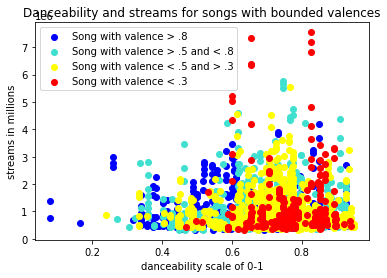

In [254]:
# Plotting songs with a high valence and varying levels of danceability against streams to see if these two values work together to impact stream counts
plt.scatter(veryLowValenceTracks['danceability'],veryLowValenceTracks['streams'], color="blue")
plt.scatter(lowValenceTracks['danceability'],lowValenceTracks['streams'], color="turquoise")
plt.scatter(highValenceTracks['danceability'],highValenceTracks['streams'], color="yellow")
plt.scatter(veryHighValenceTracks['danceability'],veryHighValenceTracks['streams'], color="red")
plt.title('Danceability and streams for songs with bounded valences')
plt.xlabel('danceability scale of 0-1')
plt.ylabel('streams in millions')
plt.legend(['Song with valence > .8', 'Song with valence > .5 and < .8', 'Song with valence < .5 and > .3', 'Song with valence < .3'])

This graph displays how the danceability of a song compares to the number of streams it has for songs that have a high valence (>.5). While there is little indication of a linear correlation, it appears that the songs with the most streams all also have a danceability of > .5. 

No longer seeing the relationship we were seeing earlier between valence and number of streams. Maybe the relationship that leads to more streams is a combination of these features together. It might be worth trying to see if there is a relationship between streams and a combination of features like valence AND loudness or tempo AND danceability

Instead of considering high valence songs, let's looks at the top streamed songs for the 1st day of every month in the year of 2017

In [255]:
top500OverYear = df.sort_values('streams', ascending=False).drop_duplicates(['artist', 'duration_ms', 'acousticness', 'danceability', 'energy'], keep='first').head(500)
top500OverYear.head(20)

index  position                                         track_name  \
200       1         1                                       Shape of You   
1000      1         1                                  Despacito - Remix   
2000      1         1                                           rockstar   
1600      1         1                           Look What You Made Me Do   
1001      2         2                                        I'm the One   
1601      2         2                                           Mi Gente   
401       2         2                           Something Just Like This   
1201      2         2      Wild Thoughts (feat. Rihanna & Bryson Tiller)   
402       3         3                    It Ain't Me (with Selena Gomez)   
2001      2         2                                             Havana   
803       4         4                                            HUMBLE.   
2202      3         3                Perfect Duet (Ed Sheeran & Beyoncé)   
601       2         2                                       Passionfruit   
201       2         2                                              Paris   
403       4         4  I Don’t Wanna Live Forever (Fifty Shades Darke...   
1203      4         4                           2U (feat. Justin Bieber)   
2002      3         3                                          New Rules   
1602      3         3                           Friends (with BloodPop®)   
2203      4         4                                             Wolves   
405       6         6                 Despacito (Featuring Daddy Yankee)   

                artist    streams  \
200         Ed Sheeran  7549041.0   
1000        Luis Fonsi  7332260.0   
2000       Post Malone  5755610.0   
1600      Taylor Swift  5547962.0   
1001         DJ Khaled  5208996.0   
1601          J Balvin  4756176.0   
401   The Chainsmokers  4581789.0   
1201         DJ Khaled  4558126.0   
402               Kygo  4529714.0   
2001    Camila Cabello  4438592.0   
803     Kendrick Lamar  4371886.0   
2202        Ed Sheeran  4250965.0   
601              Drake  4235699.0   
201   The Chainsmokers  4181293.0   
403               ZAYN  3898610.0   
1203      David Guetta  3853673.0   
2002          Dua Lipa  3758506.0   
1602     Justin Bieber  3595450.0   
2203      Selena Gomez  3590643.0   
405         Luis Fonsi  3501514.0   

                                                    url        date  \
200   https://open.spotify.com/track/7qiZfU4dY1lWllz...  2017-02-01   
1000  https://open.spotify.com/track/5CtI0qwDJkDQGwX...  2017-06-01   
2000  https://open.spotify.com/track/7wGoVu4Dady5GV0...  2017-11-01   
1600  https://open.spotify.com/track/6uFsE1JgZ20EXyU...  2017-09-01   
1001  https://open.spotify.com/track/72Q0FQQo32KJloi...  2017-06-01   
1601  https://open.spotify.com/track/2rb5MvYT7ZIxbKW...  2017-09-01   
401   https://open.spotify.com/track/6RUKPb4LETWmmr3...  2017-03-01   
1201  https://open.spotify.com/track/1OAh8uOEOvTDqkK...  2017-07-01   
402   https://open.spotify.com/track/3eR23VReFzcdmS7...  2017-03-01   
2001  https://open.spotify.com/track/0ofbQMrRDsUaVKq...  2017-11-01   
803   https://open.spotify.com/track/7KXjTSCq5nL1LoY...  2017-05-01   
2202  https://open.spotify.com/track/1bhUWB0zJMIKr9y...  2017-12-01   
601   https://open.spotify.com/track/7hDc8b7IXETo14h...  2017-04-01   
201   https://open.spotify.com/track/72jbDTw1piOOj77...  2017-02-01   
403   https://open.spotify.com/track/3NdDpSvN911VPGi...  2017-03-01   
1203  https://open.spotify.com/track/3A7qX2QjDlPnazU...  2017-07-01   
2002  https://open.spotify.com/track/2ekn2ttSfGqwhha...  2017-11-01   
1602  https://open.spotify.com/track/7nZmah2llfvLDiU...  2017-09-01   
2203  https://open.spotify.com/track/7EmGUiUaOSGDnUU...  2017-12-01   
405   https://open.spotify.com/track/4aWmUDTfIPGksMN...  2017-03-01   

                    track_id  duration_ms  acousticness  ...  energy  \
200   7qiZfU4dY1lWllzX7mPBI3     233713.0      0.581000  ...   0.65

In [256]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# plt.scatter(top500OverYear['valence'], top500OverYear['tempo'], top500OverYear['streams'])
# plt.xlabel('energy scale of 0-1')
# plt.ylabel('streams in millions')

We can start by getting the number of followers each artist has for every track entry in our dataframe. The Spotify API also provides a "popularity" index from 0 to 100, with 100 being the most popular. We will get this information, as well. There will be repetition between duplicate entries for an artist, but we are keeping these in so that we can still build a dataframe.

In [257]:
#Popularity and follower count computed at the beginning
df['popularity_index']
df['follower_count']
df.head()

index  position                               track_name            artist  \
0      1         1                                  Starboy        The Weeknd   
1      2         2                                   Closer  The Chainsmokers   
2      3         3                          Let Me Love You          DJ Snake   
3      4         4  Rockabye (feat. Sean Paul & Anne-Marie)      Clean Bandit   
4      5         5                                One Dance             Drake   

     streams                                                url        date  \
0  3135625.0  https://open.spotify.com/track/5aAx2yezTd8zXrk...  2017-01-01   
1  3015525.0  https://open.spotify.com/track/7BKLCZ1jbUBVqRi...  2017-01-01   
2  2545384.0  https://open.spotify.com/track/4pdPtRcBmOSQDlJ...  2017-01-01   
3  2356604.0  https://open.spotify.com/track/5knuzwU65gJK7IF...  2017-01-01   
4  2259887.0  https://open.spotify.com/track/1xznGGDReH1oQq0...  2017-01-01   

                 track_id  duration_ms  acousticness  ...  energy  \
0  7MXVkk9YMctZqd1Srtv4MB     230453.0       0.14100  ...   0.587   
1  7BKLCZ1jbUBVqRi2FVlTVw     244960.0       0.41400  ...   0.524   
2  3ibKnFDaa3GhpPGlOUj7ff     256733.0       0.23500  ...   0.578   
3  5knuzwU65gJK7IF5yJsuaW     251088.0       0.40600  ...   0.763   
4  1zi7xx7UVEFkmKfv06H8x0     173987.0       0.00776  ...   0.625   

   instrumentalness  liveness  loudness  speechiness  valence    tempo  \
0          0.000006     0.137    -7.015       0.2760    0.486  186.003   
1          0.000000     0.111    -5.599       0.0338    0.661   95.010   
2          0.000000     0.118    -8.970       0.0922    0.556   94.514   
3          0.000000     0.180    -4.068       0.0523    0.742  101.965   
4          0.001800     0.329    -5.609       0.0536    0.370  103.967   

                artist_id popularity_index  follower_count  
0  1Xyo4u8uXC1ZmMpatF05PJ             94.0      26720759.0  
1  69GGBxA162lTqCwzJG5jLp             84.0      17093912.0  
2  20s0P9QLxGqKuCsGwFsp7w             69.0       2055274.0  
3  6MDME20pz9RveH9rEXvrOM             80.0       4092589.0  
4  3TVXtAsR1Inumwj472S9r4             96.0      51374698.0  

[5 rows x 21 columns]

Recall that we have saved a dataframe with no duplicates.

In [258]:
no_dupes_df.head(5)

index  position                track_name        artist    streams  \
200       1         1              Shape of You    Ed Sheeran  7549041.0   
1000      1         1         Despacito - Remix    Luis Fonsi  7332260.0   
2000      1         1                  rockstar   Post Malone  5755610.0   
1600      1         1  Look What You Made Me Do  Taylor Swift  5547962.0   
1001      2         2               I'm the One     DJ Khaled  5208996.0   

                                                    url        date  \
200   https://open.spotify.com/track/7qiZfU4dY1lWllz...  2017-02-01   
1000  https://open.spotify.com/track/5CtI0qwDJkDQGwX...  2017-06-01   
2000  https://open.spotify.com/track/7wGoVu4Dady5GV0...  2017-11-01   
1600  https://open.spotify.com/track/6uFsE1JgZ20EXyU...  2017-09-01   
1001  https://open.spotify.com/track/72Q0FQQo32KJloi...  2017-06-01   

                    track_id  duration_ms  acousticness  ...  energy  \
200   7qiZfU4dY1lWllzX7mPBI3     233713.0        0.5810  ...   0.652   
1000  6rPO02ozF3bM7NnOV4h6s2     228827.0        0.2280  ...   0.816   
2000  7ytR5pFWmSjzHJIeQkgog4     181733.0        0.2470  ...   0.690   
1600  1P17dC1amhFzptugyAO7Il     211853.0        0.2040  ...   0.709   
1001  1jYiIOC5d6soxkJP81fxq2     288877.0        0.0533  ...   0.667   

      instrumentalness  liveness  loudness  speechiness  valence    tempo  \
200           0.000000    0.0931    -3.183       0.0802    0.931   95.977   
1000          0.000000    0.0967    -4.353       0.1670    0.816  178.085   
2000          0.000000    0.1010    -7.956       0.1640    0.497   89.977   
1600          0.000014    0.1260    -6.471       0.1230    0.506  128.070   
1001          0.000000    0.1340    -4.267       0.0367    0.817   80.984   

                   artist_id popularity_index  follower_count  
200   6eUKZXaKkcviH0Ku9w2n3V             91.0      73345259.0  
1000  4V8Sr092TqfHkfAA5fXXqG             78.0       9035487.0  
2000  4r63FhuTkUYltbVAg5TQnk             93.0       5174251.0  
1600  06HL4z0CvFAxyc27GXpf02             97.0      34579892.0  
1001  0QHgL1lAIqAw0HtD7YldmP             82.0       5405048.0  

[5 rows x 21 columns]

Let's look at the popularities plotted against the number of streams a song has

Text(0, 0.5, 'Streams in millions')

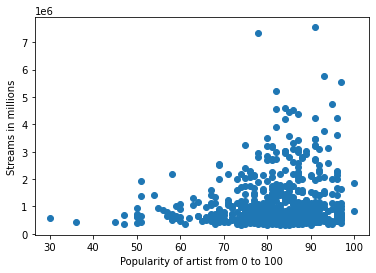

In [259]:
plt.scatter(no_dupes_df['popularity_index'], no_dupes_df['streams'])
plt.xlabel("Popularity of artist from 0 to 100")
plt.ylabel("Streams in millions")


There are artists in the top 5 positions that have relatively low popularity indices compared to other artists on the top 200 chart. Understanding how these artists got to these high positions given low popularity indices would be valuabe. Let's try to locate all of these top 200 tracks that came from artists with low popularity indices, and see if we can learn from that group.

In [260]:
# lowPopularityArtists = df.loc[df['popularity value'] < ] # Learning about songs on the top 200 chart with low artist popularity might help us understand what is actually important in trying to get a song on the top 200 chart

# Insight

In the final step of the data cycle, we draw conclusions based off our analysis to inform decisions made based on the data.

Does popularity/followers make a difference?

From our data visualization conclusions, especially our correlation matrix, it is shown that success (stream count) of a song has a positive and sometimes strong positive correlation with popularity, number of followers, loudness, valence, energy, and accousticness. When obeserving the Top 200, note that the while these correlations are merely postive, when observing the top 10, they are much more strongly positvely correlated. Liveness, tempo, and instrumentalness of have negative to strong negative correlation with success. 


The loudness of songs brings up an interesting reminder of the [Loudness War](https://en.wikipedia.org/wiki/Loudness_war) in the early 1940s. During the loudness war, even though increasing the loudness of a song ultimately reduced its fidelity (fine details), critics preferred the increasing levels. This may be an echo of the impacts of this cultural trend, or perhaps people simply like their music loud, even if at a lower quality.

We can conclude that a song by an artist with at least 200,000 followers, a popularity value of 80, a loudness value of -8, danceability x, valence x, energy x, accousticness x, is likely to enter the top 200 and potentially the top 10.

Observe the next years data (here we show our estimate was right)